In [65]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp
import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.geometry.mappings_analytical       as mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from  hylife.geometry import pull_push as p_p
import time
from hylife.utilitis_FEEC.linalg_kron import kron_matvec_3d
%load_ext jupyternotify
from sys import getsizeof

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [67]:
def Parameters(Nel       = [8,8, 2],              # mesh generation on logical domain
               bc        = [True, True, True],      # boundary conditions (True: periodic, False: else)
               p         = [4, 4, 1],         # spline degrees 
               Nq        = [6, 6, 2],
               Lx        = 4.,
               Ly        = 2.,
               Lz        = 1.,
               kind_map  = 1,
               alpha     =0.05):# number of quadrature points per element


    el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
    delta     = [1/Nel for Nel in Nel]                                            # element sizes
    T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
    t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
    NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
    NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              #number of basis functions (D functions)

    if kind_map == 1:               #slab geometry
        args_map = [kind_map, [Lx,Ly,Lz]]
    elif kind_map ==3:
        args_map = kind_map, [Lx,Ly,alpha,Lz]

    print('Parameters update Realized')

    return (Nel, bc, p, Nq, el_b, 
            delta, T, t, NbaseN, NbaseD, Lx, Ly, Lz, kind_map, args_map, alpha)

In [68]:
def Projectors_ini():
    global T, p, bc, Nq
    import hylife.utilitis_FEEC.projectors_global_fast    as projectors_global_fast
    import hylife.utilitis_FEEC.derivatives          as derivatives
    proj_glob = projectors_global_fast.projectors_3d(T, p, bc,Nq)
    der = derivatives.discrete_derivatives(T, p, bc)
    DIV  = der.DIV_3d()
    print('Projectors Initialized')
    return proj_glob, der, DIV

In [69]:
(Nel, bc, p, Nq, el_b, 
 delta, T, t, NbaseN, 
 NbaseD, Lx, Ly, Lz, kind_map,
 args_map, alpha)=Parameters(Nel=[16,16,2],Lx=4.,Ly=2., Lz=1.,p=[3,2,2])
(proj_glob, der, DIV)=Projectors_ini()

Parameters update Realized
Projectors Initialized


#### Definition of the initialization functions

In [70]:
#rho_ini_phys = lambda x, y, z : (1+0.5*np.sin(2*np.pi*(x/Lx-y/Ly)))
rho_ini_phys = lambda x, y, z : (np.sin(2*np.pi*x/Lx))

In [71]:
vx_ini_phys = lambda x, y, z : 1.
vy_ini_phys = lambda x, y, z : 0. #-0.5
vz_ini_phys = lambda x, y, z : 0.
v_f=[vx_ini_phys,vy_ini_phys,vz_ini_phys]

In [72]:
#pointwise function evaluation
def rho_ini_pw(xi1, xi2, xi3):
    rho=p_p.pull_3_pw(rho_ini_phys,xi1, xi2, xi3,*args_map)
    return rho
def density_ini(rho_ini):
    xgrid_3=proj_glob.getpts_for_PI(3)
    [x_p,y_p,z_p]=xgrid_3
    pts_mat=np.array([[[rho_ini(xi1,xi2,xi3) for xi3 in z_p] #meshgrid sparse
           for xi2 in y_p] for xi1 in x_p])
    rho_coeff =proj_glob.PI_mat(3, pts_mat)
    print('Density PI3 Projection done')
    return rho_coeff

In [73]:
#pointwise function evaluation, for velocity as a 1-form
def vx_pw(xi1, xi2, xi3,k):
    if k in [1,2,3]:
        v=p_p.pull_v_pw(v_f[0], v_f[1], v_f[2], k, xi1, xi2, xi3,*args_map)
    else:
        print('Wrong Index')
    return v
def v_eva(k):
    xgrid=[xgrid_21,xgrid_22,xgrid_23]
    [x_p,y_p,z_p]=xgrid[k-1]#evaluate velocity in the grid projector
    v_k=np.array([[[vx_pw(xi1,xi2,xi3,k) for xi3 in z_p]
           for xi2 in y_p] for xi1 in x_p])
    return v_k

In [74]:
def basis_ini():
    xgrid_21=proj_glob.getpts_for_PI(21)
    xgrid_22=proj_glob.getpts_for_PI(22)
    xgrid_23=proj_glob.getpts_for_PI(23)
    f_basemat_31= eva.FEM_evalbase_3d(3, xgrid_21, T, p, bc) #rho base
    f_basemat_32= eva.FEM_evalbase_3d(3, xgrid_22, T, p, bc)
    f_basemat_33= eva.FEM_evalbase_3d(3, xgrid_23, T, p, bc)
    print('Basis and Projection grids initialized')
    return (xgrid_21,xgrid_22,xgrid_23,f_basemat_31,f_basemat_32,f_basemat_33)

In [75]:
start_time = time.time()
[xgrid_21,xgrid_22,xgrid_23,f_basemat_31,f_basemat_32,f_basemat_33]=basis_ini()
rho_coeff_init=density_ini(rho_ini_pw)
rho_coeff=density_ini(rho_ini_pw)
V_mat=[v_eva(k) for k in [1,2,3]]
print("--- %s seconds ---" % (time.time() - start_time))

Basis and Projection grids initialized
Density PI3 Projection done
Density PI3 Projection done
--- 1.5316400527954102 seconds ---


In [76]:
start_time = time.time()
def eva_rho_t():
    global rho_coeff
    f_basemat_3=[f_basemat_31,f_basemat_32,f_basemat_33]
    rhv=[V_mat[k-1]*kron_matvec_3d(f_basemat_3[k-1],rho_coeff)for k in [1,2,3]] #correct velocity
    dire=[21,22,23]
    rhv_coeff=[proj_glob.PI_mat(dire[k],rhv[k])for k in range(3)]
    rho_t=-der.apply_DIV_3d_kron(rhv_coeff[0],rhv_coeff[2],rhv_coeff[2])
    return rho_t
rho_t_test = eva_rho_t()
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0018413066864013672 seconds ---


In [77]:
def Visualization_update(np1=100,np2=100,np3=1):
    xi1=np.linspace(0,1,np1)
    xi2=np.linspace(0,1,np2)
    xi3=np.array([0])
    x_m= np.array([[[mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 1) for i3 in range(np3)] 
                for i2 in range(np2)] for i1 in range(np1)])
    y_m= np.array([[[mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 2) for i3 in range(np3)] 
                for i2 in range(np2)] for i1 in range(np1)])
    z_m=np.array([[[mapping.f(xi1[i1],xi2[i2],xi3[i3], *args_map, 3) for i3 in range(np3)] 
                for i2 in range(np2)] for i1 in range(np1)])
    det =np.array([[[mapping.det_df(xi1[i1],xi2[i2],xi3[i3], *args_map)for i3 in range(np3)] 
                for i2 in range(np2)] for i1 in range(np1)])
    f_eva=eva.FEM_evalbase_3d(3, [xi1,xi2,xi3], T, p, bc)
    print('Visualization Updated')
    return np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det,f_eva

In [78]:
(np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det,f_eva)=Visualization_update()

Visualization Updated


<IPython.core.display.Javascript object>


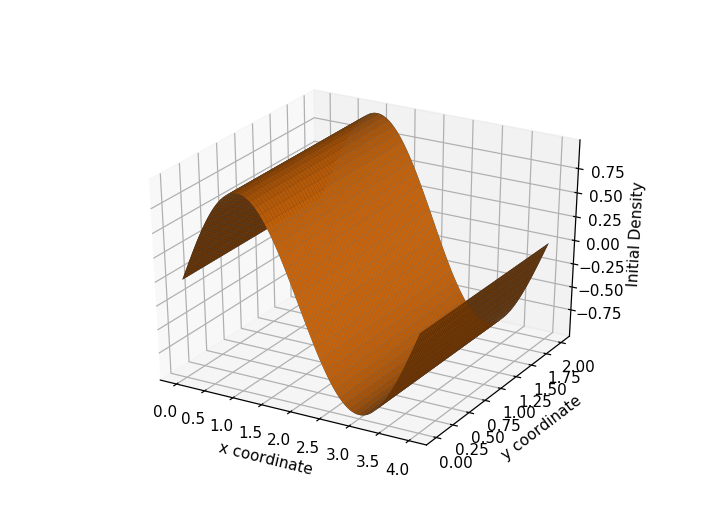

Text(0.5, 0, 'Initial Density')

In [79]:
%matplotlib notebook
rho_0_plot =kron_matvec_3d(f_eva,rho_coeff)/det
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_0_plot.reshape(np1,np2))
rho_ex_0=np.empty((np1,np2,np3))
for i1 in range(np1):
    for i2 in range(np2):
        for i3 in range(np3):
            idx=i1,i2,i3
            rho_ex_0[idx] = rho_ini_phys(x_m[idx],y_m[idx],z_m[idx])      
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_ex_0.reshape(np1,np2))
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
ax.set_zlabel('Initial Density')
#plt.savefig('/Users/juanesteban/ini.eps', format='eps')

In [80]:
np.amax(np.abs(rho_ex_0-rho_0_plot))

0.00048803047646306386

In [60]:
def density_analytical(dt,ntsteps):
    rho_ex_1=np.empty((np1,np2,np3))
    for i1 in range(np1):
        for i2 in range(np2):
            for i3 in range(np3):
                idx=i1,i2,i3
                xt = x_m[idx] -ntsteps*dt*vx_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                yt = y_m[idx] -ntsteps*dt*vy_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                zt = z_m[idx] -ntsteps*dt*vz_ini_phys(x_m[idx],y_m[idx],z_m[idx])
                rho_ex_1[idx] = rho_ini_phys(xt,yt,zt)
    return rho_ex_1

#### Total Mass $M(t_n)=\int_{V}\sum_{i=1}^{n_x+n_y+n_z}\rho_i(t_n) \Lambda_i^3(x) dV =\sum_{i=1}^{n_x+n_y+n_z}\rho_i(t_n) \int_{V}\Lambda_i^3(x) dV$ 

In [61]:
import scipy
from scipy import integrate
def rhoi_Ai(x,y,rho_coeff):
    global T
    global p
    global bc
    z=0
    z=np.array([z])
    return eva.FEM_field_3d(rho_coeff,3, [[x],[y],z], T, p, bc)[0][0][0]
def integral_x(y,rho_coeff):
    return scipy.integrate.quad(rhoi_Ai, 0, 1,args=(y,rho_coeff))[0]
#scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))

#### Compute the solution, the error evolution and the mass conservation

In [62]:
def RK4():
    global rho_coeff
    global dt
    rho_it=np.copy(rho_coeff)
    k1=eva_rho_t()
    rho_coeff=np.copy(rho_it+1/2*k1*dt)
    k2=eva_rho_t()
    rho_coeff=np.copy(rho_it+1/2*k2*dt)
    k3=eva_rho_t()
    rho_coeff=np.copy(rho_it+k3*dt)
    k4=eva_rho_t()
    rho_coeff=rho_it+dt*1/6*(k1+2*k2+2*k3+k4)
    return rho_coeff
start_time = time.time()
dt=0.1
rho_coeff=RK4()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007441282272338867 seconds ---


### RK4 Simulation for Nsteps time steps

In [63]:
%%notify
start_time = time.time()
###Control of Simulations### 
(Nel, bc, p, Nq, el_b, 
 delta, T, t, NbaseN, 
 NbaseD, Lx, Ly, Lz, kind_map,
 args_map, alpha)=Parameters(Nel=[16,16,2],p=[3,3,1],kind_map=1)
(proj_glob, der, DIV)=Projectors_ini()
rho_coeff_init=density_ini(rho_ini_pw)
rho_coeff=density_ini(rho_ini_pw)
(np1,np2,np3,xi1,xi2,xi3,x_m,y_m,z_m,det,f_eva)=Visualization_update()
# Explicit Euler Integration
###Simulation:
Nsteps=100
DT=[0.1]
L1_Error=[]
L1_Evot=[]
Linf_Error=[]
Linf_Evot=[]
#Mass_Tx=[scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))[0]]
Coeff_T=[np.sum(rho_coeff.flatten())]
Semi_Disc_mass=[]
mas=[]
for k in DT:#range(1):
    rho_coeff = rho_coeff_init
    dt=k
    l1_evo=[]
    linf_evo=[]
    for it in range(Nsteps):
        rho_coeff=RK4()
        rho_1_plot=kron_matvec_3d(f_eva,rho_coeff)/det
        rho_ex_1=density_analytical(dt,it+1)
        ###Compute L! and Linf error
        l1_error=np.sum(np.abs(rho_ex_1-rho_1_plot))
        l1_evo.append(l1_error)
        linf_error=np.amax(np.abs(rho_ex_1-rho_1_plot))
        linf_evo.append(linf_error)
        if (it/10).is_integer()==True:
            print(it)
        ###Compute Discrete and semi Discrete Mass conservation
        #Coeff_Tx.append(np.sum(rho_coeff.flatten()))
        #Mass_T.append(scipy.integrate.quad(integral_x, 0, 1,args=(rho_coeff))[0])
        #Semi_Disc_mass.append(np.sum(rho_t.flatten()))
    #mas.append(Coeff_Tx)
    L1_Evot.append(l1_evo)
    L1_Error.append(l1_error)
    Linf_Evot.append(linf_evo)
    Linf_Error.append(linf_error)
    print(l1_error)
    print(np.amax(np.abs(rho_ex_1-rho_1_plot)))
    print("--- %s seconds ---" % (time.time() - start_time))

Parameters update Realized
Projectors Initialized
Density PI3 Projection done
Density PI3 Projection done
Visualization Updated
0
10
20
30
40
50
60
70
80
90
14.066953241167072
0.002664971521224968
--- 9.49252200126648 seconds ---


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook
plt.figure()
#plt.plot(Mass_T, label='Total Mass')
plt.plot(mas[1][0:100], label='Density Coefficients')
#plt.plot( Semi_Disc_mass, label='Semi-Discrete Mass')
plt.title('Mass conservation, Nel='+str(Nel)+' p=[3,3,1]')
plt.legend()
plt.savefig('/Users/juanesteban/mass_3D_col.png')
plt.savefig('/Users/juanesteban/mass_3D_col.eps', format='eps')

In [ ]:
plt.figure()
plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[0],label=str(DT[0]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[1],label=str(DT[1]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[1],label=str(DT[1]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[2],label=str(DT[2]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[3],label=str(DT[3]))
plt.xlabel('Number of Steps')
plt.ylabel('L1 Error')
plt.title('Nel='+str(Nel))
plt.legend()

In [ ]:
plt.figure()
plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[0],label=str(DT[0]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[1],label=str(DT[1]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[1],label=str(DT[1]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[2],label=str(DT[2]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),L1_Evot[3],label=str(DT[3]))
plt.xlabel('Number of Steps')
plt.ylabel('L1 Error')
plt.title('Nel='+str(Nel))
plt.legend()

In [ ]:
len(Linf_Evotx[0])

<IPython.core.display.Javascript object>


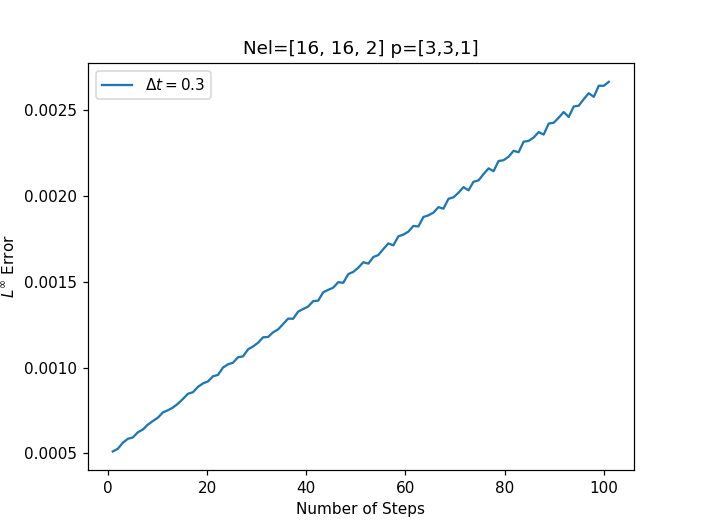

In [64]:
plt.figure()
plt.plot(np.linspace(1,Nsteps+1,Nsteps),linf_evo,label='$\Delta t=0.3$')
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),Linf_Evot[1],label='$\Delta t=0.1$')
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),Linf_Evot[2],label=str(DT[2]))
#plt.plot(np.linspace(1,Nsteps+1,Nsteps),Linf_Evot[3],label=str(DT[3]))
plt.xlabel('Number of Steps')
plt.ylabel('$L^{\infty}$ Error')
plt.title('Nel='+str(Nel)+' p=[3,3,1]')
plt.legend()
#plt.xlim(0,10)
#plt.savefig('/Users/juanesteban/RK4_3D_colx.eps', format='eps')

In [ ]:
plt.figure()
plt.plot(DT, L1_Error,'-o')
plt.xlabel('Timestep Size Steps')
plt.ylabel('L1 Error')
plt.title('Nel='+str(Nel))

In [ ]:
plt.figure()
plt.plot(DT, Linf_Error,'-o')
plt.xlabel('Timestep Size Steps')
plt.ylabel('L_inf Error')
plt.title('Nel='+str(Nel))

In [ ]:
Rl=np.linspace(-4,4,100)
il=np.linspace(-4,4,100)
stx=[]
STx=[]
sty=[]
STy=[]
for i in range(len(Rlamb)):
    for j in range(len(ilamb)):
        d=np.sqrt((1+Rlamb[i])**2+ilamb[j]**2) 
        if d<1:
            stx.append(Rlamb[i])
            sty.append(ilamb[j])
    STx.append(stx)
    STy.append(sty)

In [ ]:
rho_1_plot=eva.FEM_field_3d(rho_coeff,3, [xi1,xi2,xi3], T, p, bc)/det
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_1_plot.reshape(np1,np2),label='Simulation')
#exact density at time t=ntsteps*dt, translated with a constant velocity field
nsteps=100
rho_ex_1=density_analytical(0.3,100)
ax.plot_surface(x_m.reshape(np1,np2),y_m.reshape(np1,np2),rho_ex_1.reshape(np1,np2),label='Analytical Solution')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
ax.set_zlabel('Density-'+str(nsteps)+' iterations')
plt.savefig('/Users/juanesteban/wim.eps', format='eps')